<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Bilateral Variational Autoencoder (BiVAE)

This notebook serves as a tutorial on Bilateral Variational Autoencoder (BiVAE) model for collaborative filtering. The research paper of BiVAE [1] is presented at WSDM'21 conference. For all experiments related to BiVAE model, please refer to [this repository](https://github.com/PreferredAI/bi-vae).

The implementation of the model is from [Cornac](https://github.com/PreferredAI/cornac) [2], which is a framework for multimodal recommender systems focusing on models that utilize auxiliary data (e.g., item descriptive text and image, social network, etc).

## 0 Global Settings and Imports

In [1]:
import sys
sys.path.append("../../")
import os
import torch
import cornac
import papermill as pm
import scrapbook as sb
import pandas as pd
from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_random_split
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from reco_utils.recommender.cornac.cornac_utils import predict_ranking
from reco_utils.common.timer import Timer
from reco_utils.common.constants import SEED

print("System version: {}".format(sys.version))
print("PyTorch version: {}".format(torch.__version__))
print("Cornac version: {}".format(cornac.__version__))

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.
System version: 3.6.11 | packaged by conda-forge | (default, Nov 27 2020, 18:57:37) 
[GCC 9.3.0]
PyTorch version: 1.4.0
Cornac version: 1.11.0


In [2]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# top k items to recommend
TOP_K = 10

# Model parameters
LATENT_DIM = 50
ENCODER_DIMS = [100]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 500
BATCH_SIZE = 128
LEARNING_RATE = 0.001

## 1 Theory behind BiVAE

### 1.1 Motivation from Dyadic Data

Preference data in collaborative filtering (CF) typically consists of a set of users, a set of items, and a set of interactions, e.g., ratings, clicks, purchases between some user-item pairs.  Most of the time, preference data is being represented as an interaction matrix between user and item.  Generally, it is a form of dyadic data, with measurements associated with pairs of elements arising from two discrete sets of objects.  Naturally, there are two ways to view such data, by users (row-wise) and by items (column-wise).

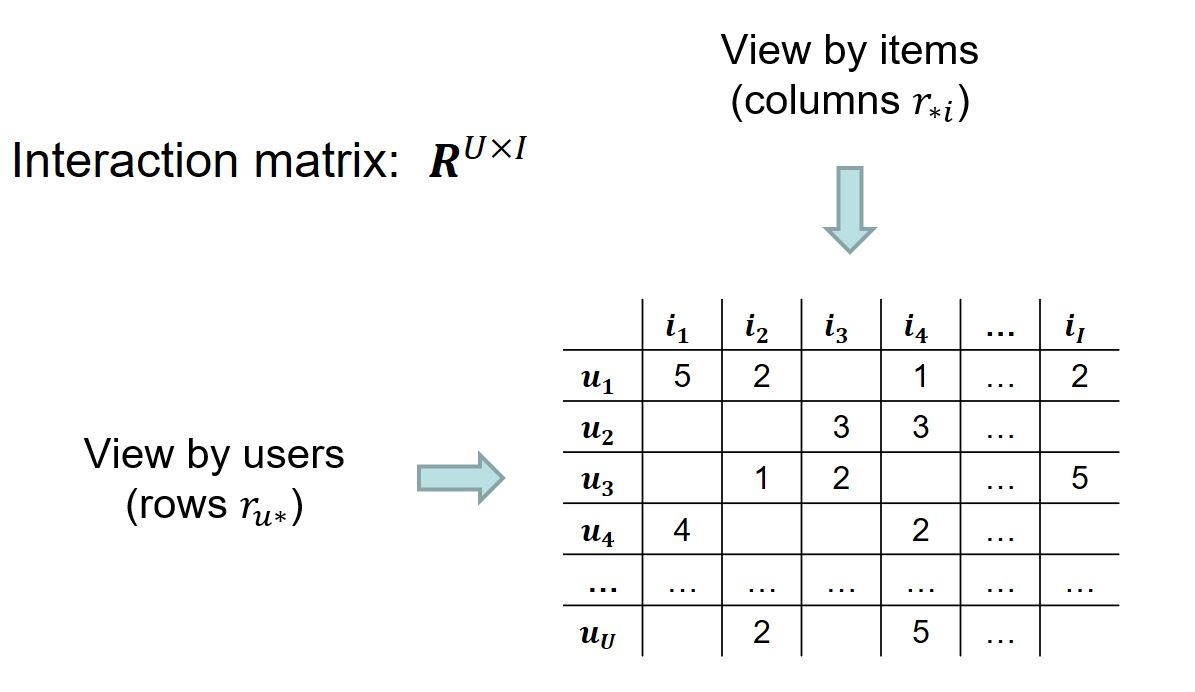


Ultimately, we would like to seek for representations for both sides of dyadic data (users and items) whose combination would be capable of explaining user-item affinities. To tackle this objective, latent factor or matrix factorization models are predominant in the context of CF. The latter owe their success mainly to their simplicity, efficiency, effectiveness, and extensibility. Nevertheless, this category of models is also known to suffer from a limited modeling capacity as it can
only capture linear patterns both in the data and latent spaces.

To go beyond this limitation, there has recently been a surge of interest in using non-linear neural-based approaches. Notably, Variational Autoencoder (VAE) [3] model has been recently applied to CF with strong performance improvements over several competitive approaches. One plausible explanation for the good results achieved by VAE on the CF task is its probabilistic nature. Indeed, the key difference of this model with neural networks is that VAE does not seek to learn deterministic representations, but rather learns distributions over these representations, thereby allowing it to account for uncertainty in the latent space. That property is particularly beneficial when dealing with sparse data where few observations are available. 

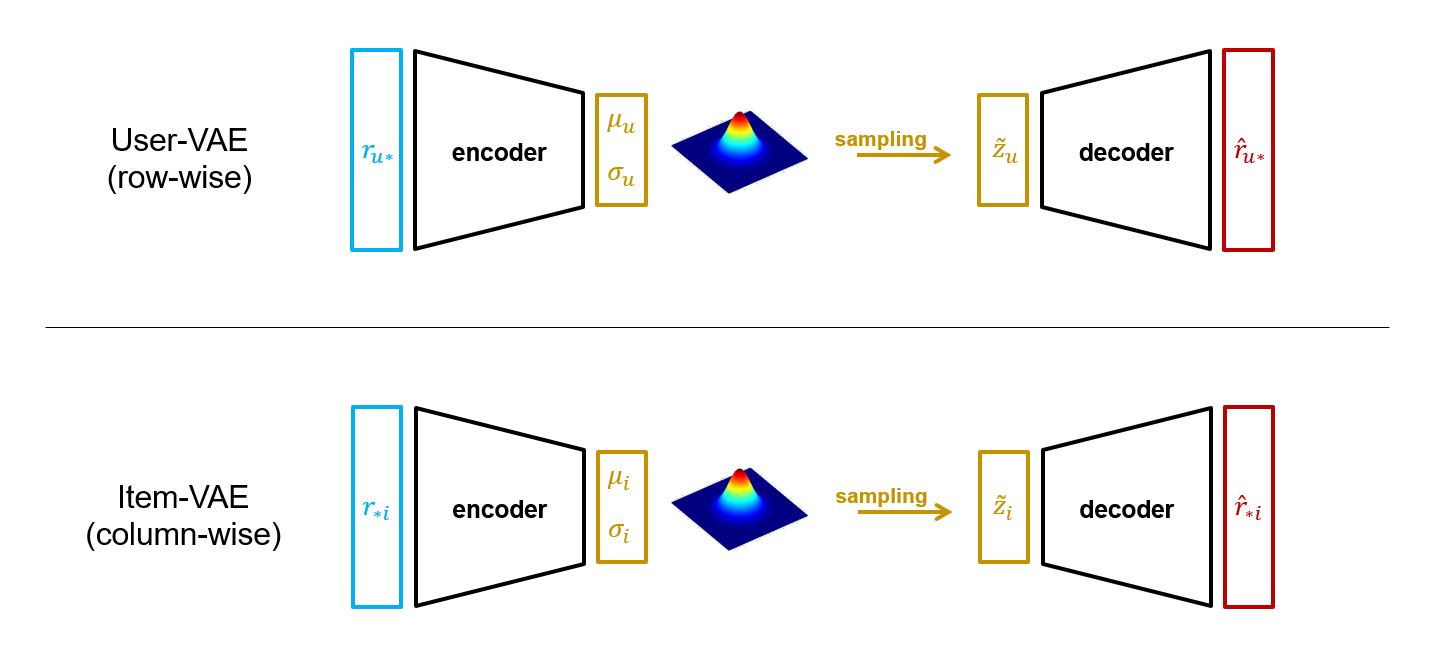

Despite its remarkable performance, VAE was originally designed for vector based-data, and thus is not in complete fidelity to the two-way nature of dyadic data. Specifically, in the User-VAE, only users are explicitly represented while items are treated as features in a vector space of users, and similarly for Item-VAE. In consequence of this mismatch between VAE and the two-way nature of preference data, it is not clear how one would extend such model on the item side in a principled way, for example to represent side information such as item textual descriptions, images, etc.

### 1.2 BiVAE Formulation

As remedy to the drawback of VAE discussed earlier, Bilateral Variational Autoencoder (BiVAE) is proposed. It consists of a generative model of user-item interactions (or dyads), and a pair of inference models (user- and item-based respectively) parameterized using multilayer neural networks, all combined together in a unified framework to auto-encode dyadic preference data. As opposed to the vanilla VAE, the proposed BiVAE is “bilateral” in that it treats users and items symmetrically, making it more apt for two-way or dyadic data. In particular, BiVAE can capture uncertainty on both sides of dyadic data, which would improve its robustness and performance on sparse preference data, compared to classical one-sided variational autoencoders.

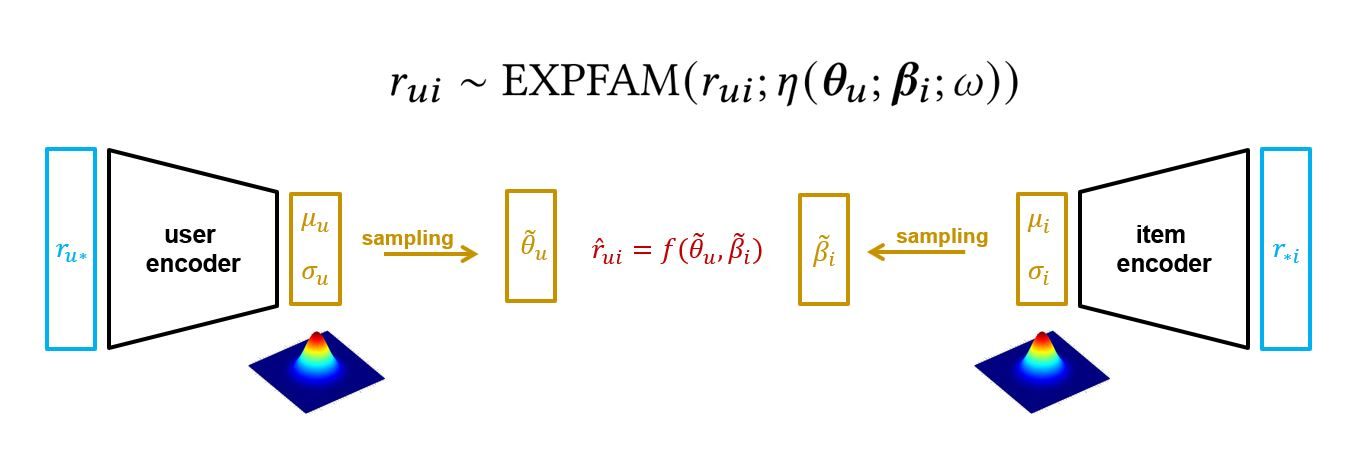

**Notation.** The data that we seek to learn from is the user-item preference matrix, of size $U\times I$, denoted $\mathbf{R} = (r_{ui})$, where $r_{ui}$ is the interaction, e.g., integer rating, between user $u$ and item $i$. We use the notation $\mathbf{r}_{u*}$ to refer to the row in $\mathbf{R}$ corresponding to user $u$. Similarly, $\mathbf{r}_{*i}$ refers to the $i$th column of $\mathbf{R}$. The latent variables are the per user and item representations denoted respectively $\mathbf{\theta}_{u}$, $\mathbf{\beta}_i \in \mathbb{R}^{K}$.

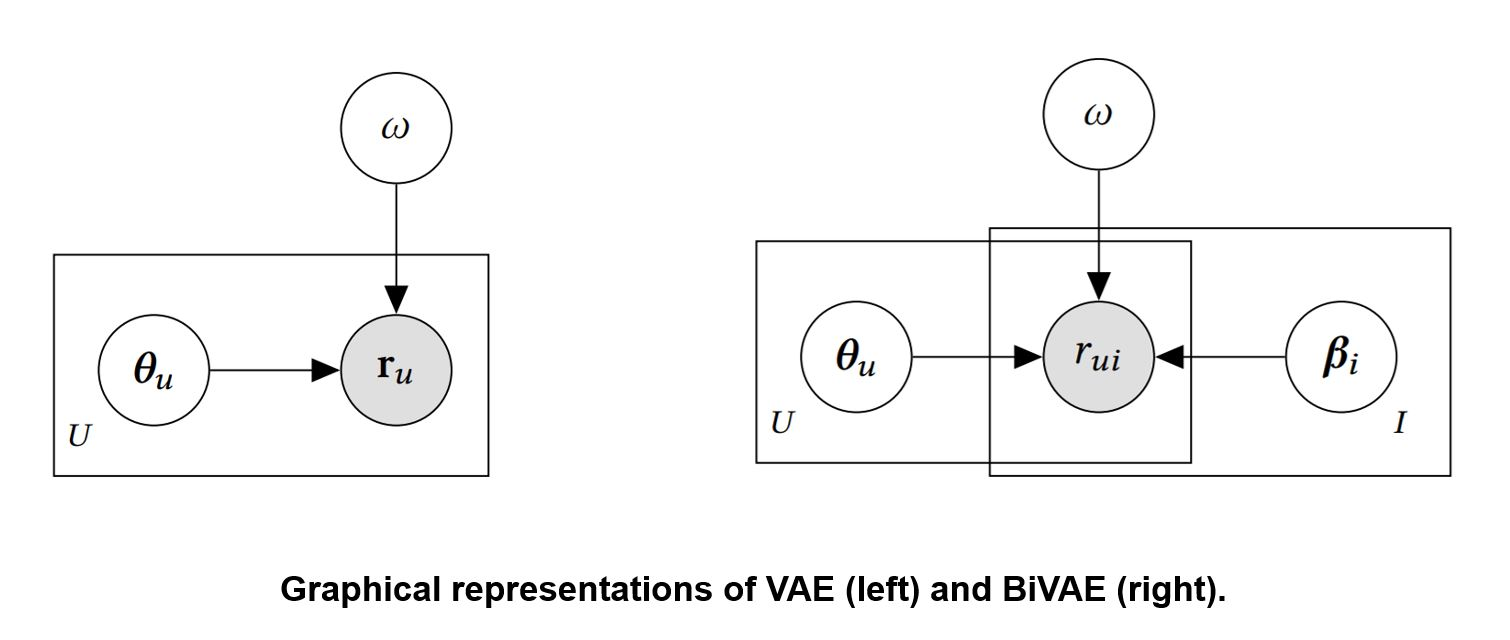

**Generative Model.** Figure above depicts BiVAE generative model, as compared to VAE, in plate notations. The latent variables are drawn from prior distributions. Without loss of generality, the Gaussian priors with diagonal covariance matrices are being used. BiVAE further adopts the standard multivariate isotropic Gaussian as the prior over all user/item latent variables. That is, $p(\bf{\theta}_u) = \mathcal{N}(\bf{0},\bf{I})$  and $p(\bf{\beta}_i) = \mathcal{N}(\bf{0},\bf{I})$, $\forall i,u$. 

Conditional on the latent variables, the observations are drawn from a univariate exponential family,

$$
p(r_{ui}|\bf{\theta}_u,\bf{\beta}_i) = \text{EXPFAM}(r_{ui}; \eta(\bf{\theta}_u; \bf{\beta}_i;\omega)) = h(r_{ui})\exp\{\eta(\bf{\theta}_u;\bf{\beta}_i;\omega)r_{ui} - a(\eta(\bf{\theta}_u;\bf{\beta}_i;\omega))\}
$$

where $h(\cdot)$, $\eta(\cdot)$ and $a(\cdot)$ denote respectively the base measure, natural parameter and log-normalizer of the exponential family. For simplicity, $r_{ui}$ is assumed to be the sufficient statistic by itself. This form of the exponential family still encompasses many popular univariate distributions, including the Poisson, Bernoulli, Gaussian with unit variance, Gamma with fixed shape parameter, etc. Therefore, BiVAE framework can accommodate various types of preference data, such as counts, binary, continuous, etc. The conditional likelihood is further parameterized in such a way that,

$$
\mathbb{E}(r_{ui}|\bf{\theta}_u,\bf{\beta}_i) = \frac{d a(\eta)}{d \eta} = g_{\omega}(\bf{\theta}_u;\bf{\beta}_i)
$$

where $g_\omega(\cdot)$ is some differentiable function (e.g., inner product, neural network, etc.) parameterized by $\omega$, combining the latent representations to output the mean of the observation $r_{ui}$.
 
Given some $\bf{R}$, the goal is to find the values of the parameters $\omega$ that would most likely have generated the observations, and to infer the posterior over the latent variables $p(\bf{\theta}_{1:U},\bf{\beta}_{1:I}|\bf{R})$. The latter will allow us to make predictions about unknown preferences and form recommendations. However, the posterior and likelihood are intractable and thereby, exact inference and learning are infeasible.  Therefore, BiVAE relies on variational Bayes (VB), a popular and efficient approach to deal with complex probabilistic models.

**Inference Model.**
The starting point of VB is to introduce a tractable inference model $q$, governed by a set of *variational parameters* $\nu$, which will be used as a proxy for the true but intractable posterior. A variational distribution, which breaks the coupling between $\beta$ and $\theta$ - a main source of intractability in our model, is chosen as:

$$
q(\bf{\theta}_{1:U},\bf{\beta}_{1:I}|\bf{R}) = q(\bf{\theta}_{1:U}|\bf{R})q(\bf{\beta}_{1:I}|\bf{R})
$$

with 

$$
\begin{align}
q(\bf{\theta}_{1:U}|\bf{R}) &= \prod_{u} q(\bf{\theta}_u|\bf{R}_{u*})\nonumber\\
q(\bf{\beta}_{1:I}|\bf{R})  &= \prod_{i} q(\bf{\beta}_i|\bf{R}_{*i})\nonumber
\end{align}
$$

Without loss of generality, the following forms are adopted:

$$
\begin{align}
q(\bf{\theta}_u|\bf{R}_{u*}) &= \mathcal{N}(\tilde{\bf{\mu}}_{\tilde\psi}(\bf{R}_{u*}),\tilde{\bf\sigma}_{\tilde\psi}(\bf{R}_{u*}))\nonumber\\
q(\bf{\beta}_i|\bf{R}_{*i}) &= \mathcal{N}(\tilde{\bf\mu}_{\tilde\phi}(\bf{R}_{*i}),\tilde{\bf\sigma}_{\tilde\phi}(\bf{R}_{*i}))\nonumber
\end{align}
$$

where $\nu=\{\tilde\phi,\tilde\psi\}$, $\tilde{\bf\mu}(\cdot)$ and $\tilde{\bf\sigma}(\cdot)$ are vector-valued functions (e.g., multilayer perceptrons) parameterized by $\tilde\phi$/$\tilde\psi$, outputting respectively the mean and covariance parameters of the variational distributions.

With $q$ in place, we can proceed with approximate inference by optimizing the Evidence Lower BOund (ELBO), w.r.t. the model $\omega$ and variational $\nu$ parameters, given in our case by,

$$
\mathcal{L} = \sum_{u,i}\mathbb{E}_{q(\bf{\theta}_u|\bf{R}_{u*})}\mathbb{E}_{q(\bf{\beta}_i|\bf{R}_{*i})}[\log p(r_{ui}|\bf{\theta}_u,\bf{\beta}_i)]
- \sum_{u} \text{KL}(q(\bf{\theta}_u|\bf{R}_{u*})|| p(\bf{\theta}_u)) - \sum_{i} \text{KL}(q(\bf{\beta}_i|\bf{R}_{*i})|| p(\bf{\beta}_i))
$$

### 1.3 Optimization

In practice, stochastic optimization is used to fit BiVAE to observations. While the KL terms in the ELBO are available analytically, the expectations over the conditional log-likelihood are intractable and thereby, the direct optimization of ELBO is not possible. To overcome this difficulty, the *reparameterization trick* is used to build an unbiased Monte Carlo estimator of the ELBO:

$$
\tilde{\mathcal{L}} = \sum_{u,i} \log p(r_{ui} | \tilde{\bf\theta}_u,\tilde{\bf\beta}_i) - \sum_{u} \text{KL}(q(\bf{\theta}_u|\bf{r}_{u*}) ||  p(\bf{\theta}_u)) - \sum_{i} \text{KL}(q(\bf{\beta}_i|\bf{r}_{*i})|| p(\bf{\beta}_i))
$$

where 

$$
\begin{align}
\tilde{\bf\theta}_u &= \mathcal{T}(\bf\epsilon,\tilde{\bf\psi})= \tilde{\bf\mu}_{\tilde\psi}(\bf{r}_{u*}) + \tilde{\bf\sigma}_{\tilde\psi}(\bf{r}_{u*})\odot\bf\epsilon \nonumber\\
\tilde{\bf\beta}_{i} &= \mathcal{T}(\bf\epsilon,\tilde{\bf\phi})= \tilde{\bf\mu}_{\tilde\phi}(\bf{r}_{*i}) + \tilde{\bf\sigma}_{\tilde\phi}(\bf{r}_{*i})\odot\bf\epsilon \nonumber
\end{align}
$$

with $\bf\epsilon \sim \mathcal{N}(\bf{0},\bf{I})$.

Now all the quantities involved are tractable. However, performing unbiased stochastic optimization over the above objective is not convenient, due to the mixing between $r_{ui}$, $\bf{r}_{u*}$ and $\bf{r}_{*i}$. To overcome this difficulty and ease subsampling of observations, the two-way nature of BiVAE model is exploited to perform alternate optimization in a Gauss-Seidel fashion. Precisely, the parameters are organized into two blocks consisting of user-related and item-related parameters respectively, then alternate the optimization of each block while holding the other one fixed.  For more details on the optimization procedure, please refer to the original paper [1].

## 2 Cornac implementation of BiVAE

BiVAE is implemented in the Cornac framework as part of the [model collections](https://github.com/PreferredAI/cornac#models).
* Detailed documentations of the BiVAE model in Cornac can be found [here](https://cornac.readthedocs.io/en/latest/models.html#module-cornac.models.bivaecf.recom_bivaecf).
* Source codes of the BiVAE implementation is available on [Cornac](https://github.com/PreferredAI/cornac/tree/master/cornac/models/bivaecf).
* For all experiments related to BiVAE, please refer to [this repository](https://github.com/PreferredAI/bi-vae).


## 3 Experiments on MovieLens


### 3.1 Load and split data

To evaluate the performance of item recommendation, we adopted the provided `python_random_split` tool for the consistency.  Data is randomly split into training and test sets with the ratio of 75/25.


Note that Cornac also cover different [built-in schemes](https://cornac.readthedocs.io/en/latest/eval_methods.html) for model evaluation.

In [3]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating"]
)

data.head()

100%|██████████| 4.81k/4.81k [00:01<00:00, 2.42kKB/s]


,userID,itemID,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [4]:
train, test = python_random_split(data, 0.75)

### 3.2 Cornac Dataset

To work with models implemented in Cornac, we need to construct an object from [Dataset](https://cornac.readthedocs.io/en/latest/data.html#module-cornac.data.dataset) class.

Dataset Class in Cornac serves as the main object that the models will interact with.  In addition to data transformations, Dataset provides a bunch of useful iterators for looping through the data, as well as supporting different negative sampling techniques.

In [5]:
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

print('Number of users: {}'.format(train_set.num_users))
print('Number of items: {}'.format(train_set.num_items))

Number of users: 943
Number of items: 1642


### 3.3 Train the BiVAE model

The BiVAE has a few important parameters that we need to consider:

- `k`: dimension of the latent space (i.e. the size of $\bf{\theta}_u$  and  $\bf{\beta}_i$ ).
- `encoder_structure`: dimension(s) of hidden layer(s) of the user and item encoders.
- `act_fn`: non-linear activation function used in the encoders.
- `likelihood`: choice of the likelihood function being optimized.
- `n_epochs`: number of passes through training data.
- `batch_size`: size of mini-batches of data during training.
- `learning_rate`: step size in the gradient update rules.

To train the model, we simply need to call the `fit()` method.

In [6]:
bivae = cornac.models.BiVAECF(
    k=LATENT_DIM,
    encoder_structure=ENCODER_DIMS,
    act_fn=ACT_FUNC,
    likelihood=LIKELIHOOD,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)

with Timer() as t:
    bivae.fit(train_set)
print("Took {} seconds for training.".format(t))

  0%|          | 0/500 [00:00<?, ?it/s]

Took 69.1472 seconds for training.


### 3.4 Prediction and Evaluation

Now that our model is trained, we can produce the ranked lists for recommendation.  Every recommender models in Cornac provide `rate()` and `rank()` methods for predicting item rated value as well as item ranked list for a given user.  To make use of the current evaluation schemes, we will through `predict()` and `predict_ranking()` functions inside `cornac_utils` to produce the predictions.

Let's measure recommendation performance of the model using top-K ranking metrics.

In [7]:
with Timer() as t:
    all_predictions = predict_ranking(bivae, train, usercol='userID', itemcol='itemID', remove_seen=True)
print("Took {} seconds for prediction.".format(t))

Took 1.7215 seconds for prediction.


In [8]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.146552
NDCG:	0.474124
Precision@K:	0.412527
Recall@K:	0.225064


In [9]:
# Record results with papermill for tests
sb.glue("map", eval_map)
sb.glue("ndcg", eval_ndcg)
sb.glue("precision", eval_precision)
sb.glue("recall", eval_recall)

## 4 Discussion

BiVAE is a new variational autoencoder tailored for dyadic data, where observations consist of measurements associated with two sets of objects, e.g., users, items and corresponding ratings.  The model is symmetric, which makes it easier to extend axiliary data from both sides of users and items.  In addition to preference data, the model can be applied to other types of dyadic data such as documentword matrices, and other tasks such as co-clustering.  

In the paper, there is also a discussion on Constrained Adaptive Priors (CAP), a proposed method to build informative priors to mitigate the well-known posterior collapse problem. We have left out that part purposely, not to distract the audiences.  Nevertheless, it is very interesting and worth taking a look.  

[This repository](https://github.com/PreferredAI/bi-vae) will provide you a more comprehensive set of experiments related to BiVAE.

## References

1. Quoc-Tuan Truong, Salah, Aghiles, and Hady W. Lauw. "Bilateral Variational Autoencoder for Collaborative Filtering." Proceedings of the 14th ACM International Conference on Web Search and Data Mining. 2021. https://dl.acm.org/doi/pdf/10.1145/3437963.3441759
2. Salah, Aghiles, Quoc-Tuan Truong, and Hady W. Lauw. "Cornac: A Comparative Framework for Multimodal Recommender Systems." Journal of Machine Learning Research 21.95 (2020): 1-5. https://cornac.preferred.ai
3. Liang, Dawen, et al. "Variational autoencoders for collaborative filtering." Proceedings of the 2018 World Wide Web Conference. 2018.